Product Owner have to choose between two KPIs (group of metrics) of his product and invest in one of possible strategies - backlog prioritization. Ads or CRO, attraction or activation or retention. Here I use ML scores of prediction as a measure of KPI selection. I look how KPI/metrics helps to predict possible cash flow. Standard statistical measures like correlation fail while nonlinear ML models give insight. It works on relatively small data of 1092 records. Ensemble voting, binning of target and dimension reduction are involved to avoid overfit. I explore two groups of metrics. First (I) corresponds to conversion - bounce rate, depth of view, conversion to contact page, time of session. Second (II) corresponds to traffic: number of sessions, new visitors, views. The target function is a number of commercial offers/day. Input features correspond to the New Visitors segment from organic search. 

In [204]:
print('Namaste!')

Namaste!


Import libraries:

In [205]:
import numpy as np 
import pandas as pd 
from pandas import set_option
import matplotlib.pyplot as plt 
from pylab import plot, ylim, xlim, show, xlabel, ylabel, grid 
from numpy import linspace, loadtxt, ones, convolve
from statistics import median 
from statistics import mean 
from statistics import stdev 
from math import log
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold 
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from operator import add
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression

Define custom functions:

In [206]:
def standart(x):#normalize to (0,1) interval
    max_value=x.max();
    min_value=x.min()
    z=(x-min_value) / (max_value - min_value)
    return z

def cormap(x):#correlation map
  corr=x.corr();fig=plt.figure(figsize=(10, 7))
  g=sns.heatmap(corr,annot=True,linewidths=.2, cbar_kws={"orientation": "horizontal"})
  plt.show()
    
def get_class(x):
    class_type=[]
    for item in list(x):
        if 0<=item<0.33:   class_type.append(0) #1 class  
        if 0.33<=item<0.66: class_type.append(1) #2 class
        if 0.66<=item<=1:  class_type.append(4) #3 class
    return class_type

def pca(x,y):#principal components visual output
  pca=PCA()
  pca.fit(y) 
  PCA(copy=True)
  features=x
  pca.explained_variance_=standart(pca.explained_variance_)
  pca.explained_variance_=list(np.array(pca.explained_variance_)*100)
  print('\nInput of components - PCA:')
  for i in range(0,len(pca.explained_variance_)):
    print(str(x[i])+': '+str(int(pca.explained_variance_[i]))+'%')
    i=i+1

def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

Read data from three files with crm and web data, parsed through web analytics API. Sessions, converted into the contact page visit are recorded in contacts.xlsx, while all session correspond to all_pages.xlsx. Data with daily commercial offers is reccorded in crm.xls.  

In [207]:
df_all=pd.read_excel('all_pages.xlsx');df_contacts=pd.read_excel('contacts.xlsx');df_crm=pd.read_excel('crm.xlsx')

df_all_contacts=df_all.merge(df_contacts,how='left',left_on='Date',right_on='Date')
df_all_contacts['Visits_contacts']=df_all_contacts['Visits_contacts'].fillna(0)
df=df_all_contacts.merge(df_crm,how='left',left_on='Date',right_on='Date');df['Offers']=df['Offers'].fillna(0)
df['Conversion']=100*df['Visits_contacts']/df['Visits'];del df['Visits_contacts'];df['OFFERS']=df['Offers'];del df['Offers']

In [208]:
column_names=list(df.columns.values)
print('All fields:',column_names)
print('Data Start:',list(df['Date'])[0])
print('Data End:',list(df['Date'])[-1])
print('Number of records:', len(df))

All fields: ['Date', 'Visits', 'Viewers', 'Views', 'BR', 'Depth', 'Time', 'Conversion', 'OFFERS']
Data Start: 2016-05-09 00:00:00
Data End: 2019-05-07 00:00:00
Number of records: 1092


Convert features to the (0,1) interval:

In [209]:
for item in df.columns.values: 
    df[item]=standart(df[item])   
del df['Date']        

Let's find the proportion of days with positive offers number. 

In [210]:
offers_positive=len(df[df['OFFERS']>0])
general_length=len(df)
print('Number of days with [offers>0] number is '+str(round(100*offers_positive/general_length))+'%')

Number of days with [offers>0] number is 70%


Make correlation map and scatter map

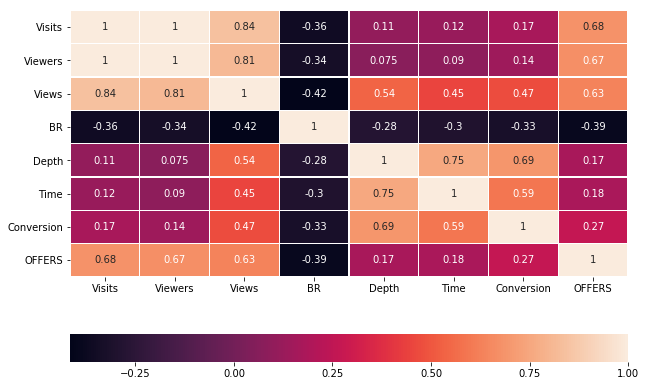

In [211]:
cormap(df)

We can see that Offers are correlated mostly with Visits (sessions)/Viewers - traffic metrics. Small correlation with conversion features. Let's look at the basic statistical properties. Most of PMF lies in (0,0.5) interval.

In [212]:
description=df['OFFERS'].describe()
print('Common description:\n')
print(description)
print('\nPercentile of 10%:',round(df['OFFERS'].quantile(0.1),2))
print('Percentile of 90%:',round(df['OFFERS'].quantile(0.9),2))

Common description:

count    1092.000000
mean        0.220555
std         0.193650
min         0.000000
25%         0.000000
50%         0.230769
75%         0.346154
max         1.000000
Name: OFFERS, dtype: float64

Percentile of 10%: 0.0
Percentile of 90%: 0.46


We may test classification using binning of (0,1) into 3 equal classes.

In [213]:
df_binary_fa=df.copy();df_binary_fa['Offers_BIN']=get_class(df_binary_fa['OFFERS']);del df_binary_fa['OFFERS']

If classiicator works well we may predict in what range the target lays. Let's split features and target. Let's make an estimation of feature importance based on tree classifier with 100 of experiments and Principal Component Analysis. 

In [214]:
model=ExtraTreesClassifier(n_estimators=100)
tree_features=['Visits','Viewers','Views','BR','Depth','Time','Conversion','OFFERS']

array=df_binary_fa.values
X=array[:,0:7];Y=array[:,7]
model.fit(X,Y)
imp=list(model.feature_importances_)
imp=[round(x*100/max(imp)) for x in imp]

print('\nInput of components - Tree:')  
for x,y in zip(tree_features,imp): 
    print(str(x)+':'+str(y)+'%')
    
column_names=df_binary_fa.columns
del df_binary_fa['Offers_BIN']
pca(column_names,df_binary_fa)  


Input of components - Tree:
Visits:100.0%
Viewers:88.0%
Views:84.0%
BR:69.0%
Depth:59.0%
Time:62.0%
Conversion:63.0%

Input of components - PCA:
Visits: 100%
Viewers: 30%
Views: 12%
BR: 5%
Depth: 2%
Time: 0%
Conversion: 0%


Traffic metrics in top. Now we can move forward to the ensemble of simple classifiers/predictors. We look if prediction factor analysis corresponds to standard methods like PCA/Tree/Correlation. We move to classifiers. First try with all features. We use ensemble of 6 voting estimators. We get score for all features. We first make hyperparameter tuning for KNN model.

In [215]:
split_num=5 #number of splits for cross validation

#define dataframe#
df_binary=df.copy();df_binary['Offers_BIN']=get_class(df_binary['OFFERS']);del df_binary['OFFERS']
array=df_binary.values
X=array[:,0:7];Y=array[:,7]
#/define dataframe#

#building the ensemble#
model=KNeighborsClassifier()
n_neighbors=np.arange(5,20,1)
param_grid=dict(n_neighbors=n_neighbors)
grid=GridSearchCV(estimator=model,param_grid=param_grid,cv=split_num,iid=True)
grid.fit(X, Y)

kn=KNeighborsClassifier(n_neighbors=grid.best_estimator_.n_neighbors);gb=GaussianNB()
dt=DecisionTreeClassifier(criterion='entropy');sv=SVC(gamma='auto')
ab=AdaBoostClassifier(n_estimators=100,random_state=7)
gb=GradientBoostingClassifier(n_estimators=100,random_state=7)
mlp=MLPClassifier(activation='relu', hidden_layer_sizes=(3,1), random_state=1, solver='lbfgs')

estimators=[]
estimators.extend([('kn',kn),('naive',gb),('dt',dt),('sv',sv),('ab',ab),('gb',gb),('mlp',mlp)])
ensemble=VotingClassifier(estimators)
#/building the ensemble#
   
#output of results#
results=cross_val_score(ensemble,X,Y,cv=split_num)
print('Average score:'+str(round(100*mean(results),1))+str('%'))
print('Deviation of score:'+str(round(100*stdev(results),1))+str('%'))
#/output of results#

Average score:68.1%
Deviation of score:1.9%


Great result. Now we remove conversion metrics and leave sessions only:

In [216]:
#define dataframe#
del df_binary['BR']
del df_binary['Depth']
del df_binary['Time']
del df_binary['Conversion']
del df_binary['Views']
del df_binary['Viewers']
#/define dataframe#

#define array#
array=df_binary.values
X=array[:,0:1];Y=array[:,1]
#/define array#
   
#output of results#
results=cross_val_score(ensemble,X,Y,cv=split_num)
print('Average score:'+str(round(100*mean(results)))+str('%'))
print('Deviation of score:'+str(round(100*stdev(results),1))+str('%'))
#/output of results#

Average score:70.0%
Deviation of score:3.6%


The result is comparable. Any other feature combinations won't improve the mean accuracy. I don't represent these calculations here for fast 'onLoad'. However you may check it and test any other combination. Let's test classifier ensemble for cv split number stability.

In [217]:
cv_num=[]
score_cv=[]
S=[]
R=[]
for item in range(3,16):
    
    #building the ensemble#
    model=KNeighborsClassifier()
    n_neighbors=np.arange(5,20,1)
    param_grid=dict(n_neighbors=n_neighbors)
    grid=GridSearchCV(estimator=model,param_grid=param_grid,cv=item,iid=True)
    grid.fit(X, Y)

    kn=KNeighborsClassifier(n_neighbors=grid.best_estimator_.n_neighbors);gb=GaussianNB()
    dt=DecisionTreeClassifier(criterion='entropy');sv=SVC(gamma='auto')
    ab=AdaBoostClassifier(n_estimators=100,random_state=7)
    gb=GradientBoostingClassifier(n_estimators=100,random_state=7)
    mlp=MLPClassifier(activation='relu', hidden_layer_sizes=(3,1), random_state=1, solver='lbfgs')

    estimators=[]
    estimators.extend([('kn',kn),('naive',gb),('dt',dt),('sv',sv),('ab',ab),('gb',gb),('mlp',mlp)])
    ensemble=VotingClassifier(estimators)
    #/building the ensemble#
    
    #output of results#
    cv_scores=list(cross_val_score(ensemble,X,Y,cv=item))
    cv_scores=[round(100*x) for x in cv_scores]
    cv_num.append(item)#split number
    score_cv.append(mean(cv_scores)) #score
    R.append(max(cv_scores)-min(cv_scores))#R
    S.append(stdev(cv_scores)) #S
    print('Number of cv: '+str(item)+' Average score: '+str(round(mean(cv_scores)))+'%')
    #/output of results#

Number of cv: 3 Average score: 69.0%
Number of cv: 4 Average score: 70.0%
Number of cv: 5 Average score: 71.0%
Number of cv: 6 Average score: 70.0%
Number of cv: 7 Average score: 68.0%
Number of cv: 8 Average score: 68.0%
Number of cv: 9 Average score: 69.0%
Number of cv: 10 Average score: 69.0%
Number of cv: 11 Average score: 68.0%
Number of cv: 12 Average score: 68.0%
Number of cv: 13 Average score: 68.0%
Number of cv: 14 Average score: 67.0%
Number of cv: 15 Average score: 69.0%


Quite stable. Let's do RS analysis to look whether cv test is scale-invariant.

Hurst factor: 0.29
R2: 0.91


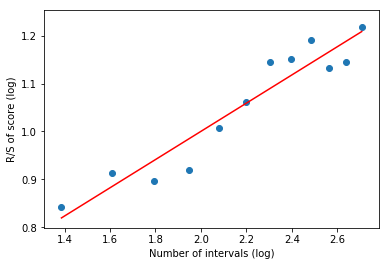

In [218]:
log_N=[log(x) for x in cv_num][1:]
log_RS=[log(x/y) for x,y in zip(R,S)][1:]

b,m=polyfit(log_N,log_RS,1)
print('Hurst factor:',round(100*m)/100)
R2=round((np.corrcoef(log_N,log_RS)[0,1])**2,2)
print('R2:',R2)

plt.scatter(log_N,log_RS)
plt.plot(np.unique(log_N),np.poly1d(np.polyfit(log_N,log_RS,1))(np.unique(log_N)),'r')
plt.xlabel('Number of intervals (log)')
plt.ylabel('R/S of score (log)')
plt.show()

H<0.5 shows scale invariance. Let's move to regression models. I include regression with regularisation into the stacking ensemble of models. First I define the new dataframe. The sessions feature only is used.

In [219]:
split_num=5

df_reg=df.copy();df_reg['Offers_REG']=df_reg['OFFERS'];del df_reg['OFFERS']
del df_reg['BR'];del df_reg['Depth'];del df_reg['Time'];del df_reg['Conversion']
del df_reg['Views'];del df_reg['Viewers']
array=df_reg.values
X=array[:,0:1];Y=array[:,1]

mod=Ridge();alphas=np.arange(0,1,0.02)
param_grid=dict(alpha=alphas)
grid=GridSearchCV(estimator=mod,param_grid=param_grid,cv=split_num)
grid.fit(X, Y)
rdg=Ridge(alpha=grid.best_estimator_.alpha)

mod=KNeighborsRegressor()
n_neighbors=np.arange(5,20,1)
param_grid=dict(n_neighbors=n_neighbors)
grid=GridSearchCV(estimator=mod,param_grid=param_grid,cv=split_num,iid=True)
grid.fit(X, Y)
knn=KNeighborsRegressor(n_neighbors=grid.best_estimator_.n_neighbors)

model=StackingRegressor(regressors=[rdg,knn], meta_regressor=rdg)
results=cross_val_score(model, X, Y, cv=split_num, scoring='r2')

print('R2 for Ridge cross validation:'+str(round(100*results.mean()))+'%')
print('Deviation of validation score:'+str(round(100*results.std()))+'%')

scores=[]
scores_dev=[]
scales=[]
S=[]
R=[]
for item in range(3,40):
    cv_scores=list(cross_val_score(model, X, Y,cv=item))
    cv_scores=[round(100*x) for x in cv_scores]
    scores.append(mean(cv_scores))
    scores_dev.append(stdev(cv_scores))
    R.append(max(cv_scores)-min(cv_scores))
    S.append(stdev(cv_scores))
    scales.append(item)

R2 for Ridge cross validation:52.0%
Deviation of validation score:6.0%


It's not the best result. Let's look at the stability in the relation to cv number of intervals. We can see that regression model is scale invariant as Hurst<0.5.

Hurst factor: 0.33
R2: 0.87


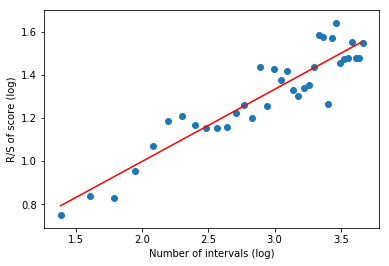

In [220]:
X=[log(x) for x in scales][1:]#Log(N)
Y=[(x/y) for x,y in zip(R,S)][1:]#(RS)
Y=[log(x) for x in Y]#log(RS)

b,m=polyfit(X,Y,1)
print('Hurst factor:',round(100*m)/100)
R2=round((np.corrcoef(X,Y)[0,1])**2,2)
print('R2:',R2)
plt.scatter(X,Y)
plt.plot(np.unique(X),np.poly1d(np.polyfit(X,Y,1))(np.unique(X)),'r')
plt.xlabel('Number of intervals (log)')
plt.ylabel('R/S of score (log)')
plt.show()

So, finally, traffic is a most powerful KPI. PO may focus on traffic attraction more than CRO. Let's insert moving averages with window of Q1 for sessions,BR and offers to verify the result.   

In [221]:
print(df.head())

     Visits   Viewers     Views        BR     Depth      Time  Conversion  \
0  0.054348  0.051136  0.027961  0.233766  0.054189  0.022267    0.000000   
1  0.288043  0.267045  0.199013  0.333333  0.095207  0.209282    0.395062   
2  0.304348  0.261364  0.384868  0.225564  0.233987  0.346259    0.561404   
3  0.293478  0.267045  0.203947  0.467532  0.096185  0.142217    0.145455   
4  0.222826  0.232955  0.115132  0.459184  0.053221  0.084290    0.063492   

     OFFERS  
0  0.038462  
1  0.000000  
2  0.230769  
3  0.346154  
4  0.115385  


Let's look at the moving averages with 2W window.

In [222]:
Sessions=list(df['Visits'])
Offers=list(df['OFFERS'])
BR=list(df['BR'])
CR=list(df['Conversion'])

ma_window=40

x=range(len(Sessions))
y_av_ses=list(movingaverage(Sessions,ma_window))
y_av_offers=list(movingaverage(Offers,ma_window))
y_av_br=list(movingaverage(BR,ma_window))
y_av_cr=list(movingaverage(CR,ma_window))
y_av_kpi=[(x-y) for x,y in zip(y_av_ses,y_av_offers)]

df_ma={'Sessions':y_av_ses,'Offers':y_av_offers,'Bounce rate':y_av_br,'Conversion rate':y_av_cr,'Gap':y_av_kpi}
df_ma=pd.DataFrame(df_ma)
print(df_ma.corr())

                 Sessions    Offers  Bounce rate  Conversion rate       Gap
Sessions         1.000000  0.663826     0.004595        -0.624316  0.910191
Offers           0.663826  1.000000    -0.159968        -0.242751  0.294442
Bounce rate      0.004595 -0.159968     1.000000        -0.088902  0.094464
Conversion rate -0.624316 -0.242751    -0.088902         1.000000 -0.663328
Gap              0.910191  0.294442     0.094464        -0.663328  1.000000


<Figure size 432x288 with 0 Axes>

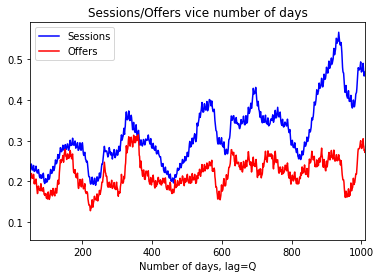

<Figure size 432x288 with 0 Axes>

In [223]:
plt.plot(x, y_av_ses,'b')
plt.plot(x, y_av_offers,'r')
plt.title('Sessions/Offers vice number of days')
plt.xlabel('Number of days, lag=Q')
plt.xlim(right=1010,left=50)
plt.gca().legend(('Sessions','Offers'))
plt.figure()

<Figure size 432x288 with 0 Axes>

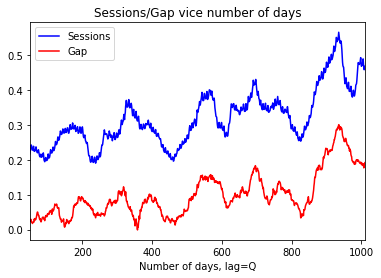

<Figure size 432x288 with 0 Axes>

In [224]:
plt.plot(x, y_av_ses,'b')
plt.plot(x, y_av_kpi,'r')
plt.title('Sessions/Gap vice number of days')
plt.xlabel('Number of days, lag=Q')
plt.xlim(right=1010,left=50)
plt.gca().legend(('Sessions','Gap'))
plt.figure()

These charts give a visual interpretation of traffic KPI importance. However the gap between Offers and Sessions is growing - almost 90% of correlation with traffic. It gives and idea that traffic 'quantity' increase is reached by its quality.